<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/image_segmentation3(20230409_v6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.2 MB/s eta 0:00:00


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from skimage.io import imread, imshow, imread_collection, concatenate_images
%matplotlib inline 

In [3]:
# import segmentation models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
sm.__version__

'1.0.1'

In [ ]:
# split dataset into 85% train, 10% validation and 5% test
# during training create a validation set from training set
dataset,info = tfds.load('oxford_iiit_pet:3.*.*', 
                                split=['train+test[:70%]',
                                       'test[70%:90%]',
                                       'test[90%:]'],
                                with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [7]:
print(f'Number of images/masks in train set: {len(dataset[0])}')
print(f'Number of images/masks in validation set: {len(dataset[1])}')
print(f'Number of images/masks in test set: {len(dataset[2])}')

Number of images/masks in train set: 6248
Number of images/masks in validation set: 734
Number of images/masks in test set: 367


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [118]:
img_height = 128
img_width = 128

In [119]:
# Function to Normalize pixel values to 0 to 1 from 0 to 255 and subtract 1 from
# the segmentation mask, resulting in labels that are : {0, 1, 2} from {1,2,3}
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [120]:
# Function to resize images and segmentation masks
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (img_height, img_width))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (img_height, img_width),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [121]:
train_dataset = dataset[0].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [190]:
n 

3000

In [215]:
# Creat train numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list

# Allocate memory for numpy arrays
# train images
X_train = np.zeros(shape=(3000,128,128,3)) 
# train mask
Y_train = np.zeros(shape=(3000,128,128,1))

idx = 0
for img,mask in train_dataset.take(3000):
    X_train[idx] = img
    Y_train[idx] = mask
    idx += 1

  

In [216]:
len(X_train)

3000

In [217]:
# Creat val numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list

# Allocate memory for numpy arrays
# train images
X_val = np.zeros(shape=(300,128,128,3)) 
# train mask
Y_val = np.zeros(shape=(300,128,128,1))

i = 0
for img,mask in train_dataset.skip(3000).take(300):
    X_val[i] = img
    Y_val[i] = mask
    i += 1

In [221]:
len(Y_val)

300

In [227]:
# Display image, repective mask and model prediction 
def display(data_list):
  plt.figure(figsize=(12,8))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(data_list)):
    plt.subplot(1, len(data_list), i+1)
    plt.title(title[i])
    plt.imshow(data_list[i])
    plt.axis('off')
  plt.show()



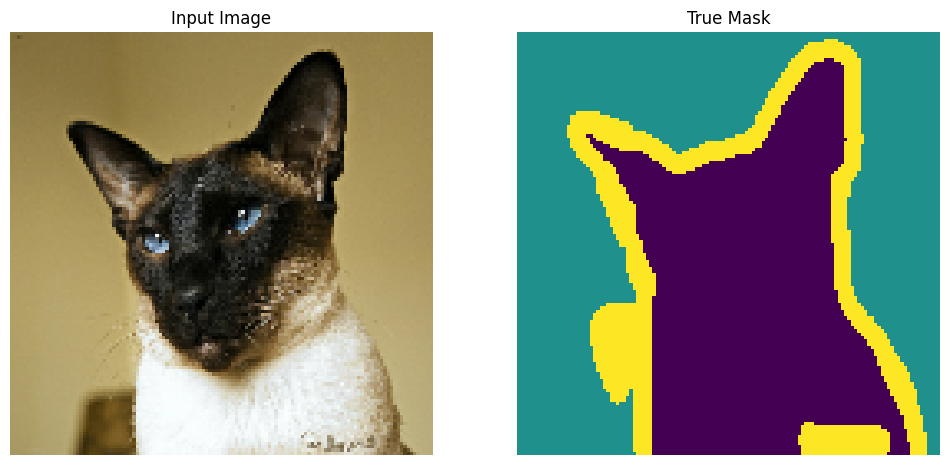

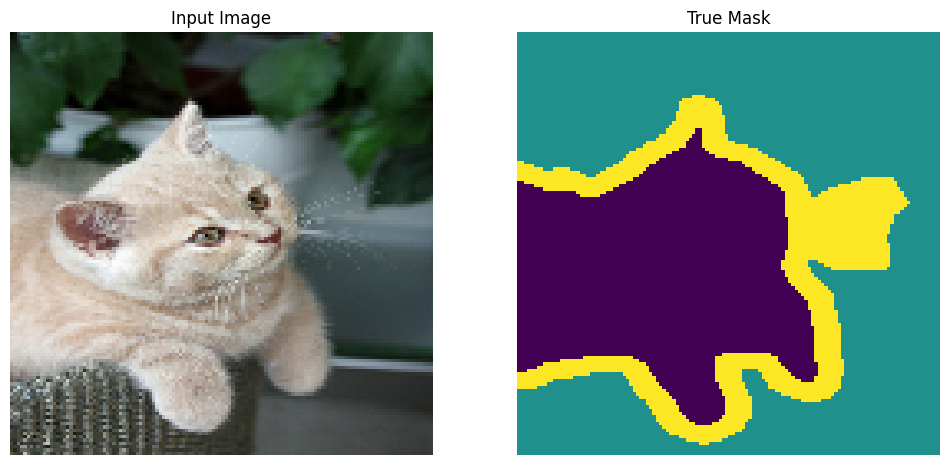

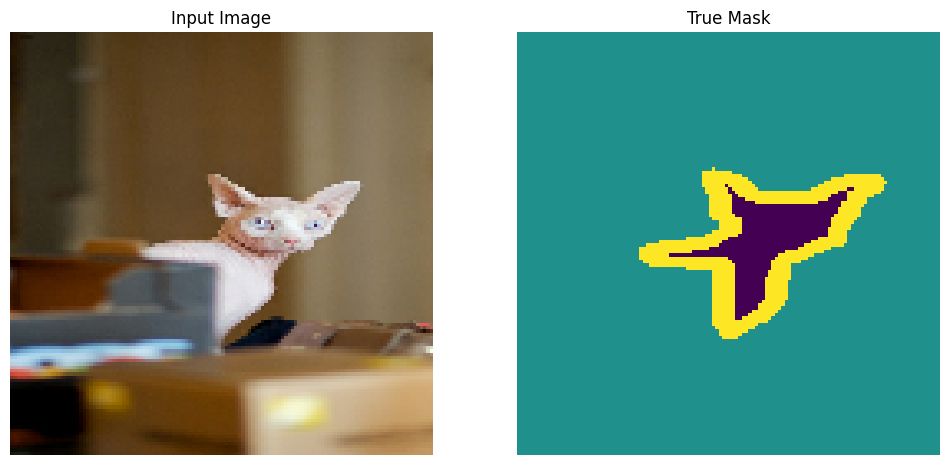

In [228]:
# Randomly select an image and its respective mask 3 times for display
for i in range(3):
  num = np.random.randint(0,3000)
  display([X_train[num],Y_train[num]])